<a href="https://www.kaggle.com/code/chakreshkrsingh/cnn-application-important-points-to-remember?scriptVersionId=159431450" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### CNN application for image classification

This notebook is submitted as a final project for the IBM DeepLearning course. The notebook proceeds as follows - 

<ol>
    <li>  We take a labelled animal dataset and prepare it for classification using Neural Networks </li>
    <li>  We use a regular Neural Network architecture with Dense layers for training the data-set and show that it performs poorly for our case. </li>
    <li> We show an example of Sobel operator for edge detection to explain why CNN's 
        are better for image datasets.</li>
    <li> Next, we introduce the CNN into our model and see the increase in performance.</li>
    <li> We discuss the important points to remember and common errors while working with CNN</li>
    <li> Future problems are discussed. </li>
    
</ol>

## Importing the necessary libraries

In [1]:
from PIL import Image, ImageDraw, ImageOps
from skimage import io,color
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.losses import CategoricalCrossentropy,SparseCategoricalCrossentropy,BinaryCrossentropy
from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten
from tensorflow.keras import layers, datasets
from sklearn.model_selection import train_test_split

import pathlib
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import os
import tensorflow as tf
print(tf.__version__)


%matplotlib inline 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.11.0


In [ ]:
# os.getcwd()


True Image Shape ---  (512, 512, 3)


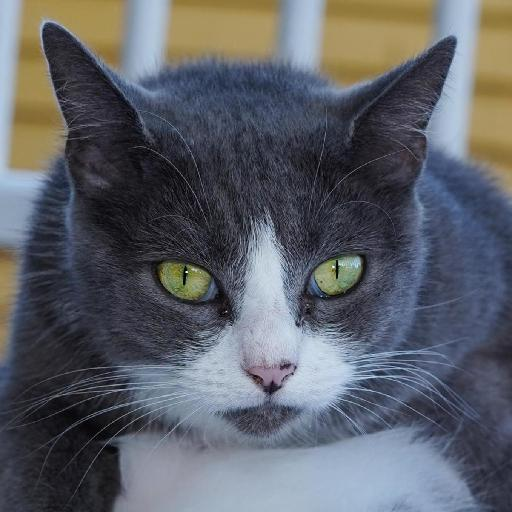

In [4]:
## defining the root path for the data_set

root_path = '/kaggle/input/cat-dog-wild-animal-dataset/train/'


### loading an example image 

img0 = Image.open(root_path+'cat/flickr_cat_000005.jpg')
print('True Image Shape --- ', np.asarray(img0).shape)
img0

Gray Scaled and Resized Shape (150, 150)


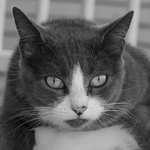

In [5]:
### converitng the image to gray-scale and resizing it 
img_rows, img_cols = 150, 150
img = Image.fromarray(np.uint8(img0)).convert('L')
img_gray = img.resize((img_rows, img_cols), Image.LANCZOS)
print('Gray Scaled and Resized Shape',np.array(img_gray).shape)
img_gray

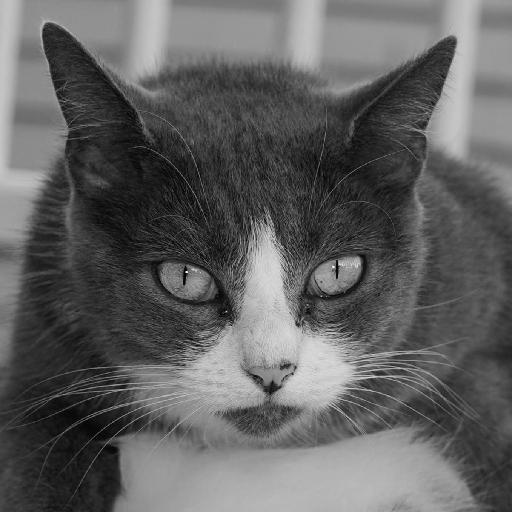

In [6]:
#### Another way of converting to gray_scale is by using ImageOps 

gray = ImageOps.grayscale(img0)
gray 

### note that this does not do any-resizing.

Resized the original image, New shape --  (150, 150, 3)


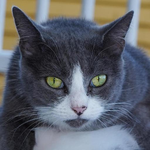

In [7]:
#### if you want to resize without converting to gray-scale 
### This is usefull if you have really large images and want to convert it to smaller ones without loosing information

red_img = img0.resize((img_rows, img_cols), Image.LANCZOS)
print('Resized the original image, New shape -- ', np.array(red_img).shape)
red_img

### Pre-processing and cleaning the data-set

In [8]:
species = ['cat','dog','wild']

X_cat,Y_cat,_,_,_ = create_dataset_from_path(root_path+'cat/',img_rows,img_cols,'cat')
X_dog,Y_dog,_,_,_ = create_dataset_from_path(root_path+'dog/',img_rows,img_cols,'dog')
X_wild,Y_wild,_,_,_ = create_dataset_from_path(root_path+'wild/',img_rows,img_cols,'wild')

In [9]:
X_data = np.vstack([X_cat,X_dog,X_wild])
Y_labls = np.hstack([Y_cat,Y_dog,Y_wild])

### Transforming the data-set Target variabel to One-hot encoded Targets. This is important to do if you are working with multi-class classification and using the Cross-Entropy as your loss function. 

In [10]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(np.array(Y_labls).reshape(-1,1))

y_train = one_hot_encoder.transform(np.array(Y_labls).reshape(-1,1))

In [11]:
### Converting and scaling the Input data .. it is important 

X_data = X_data.astype('float32')/255

X_train, x_test, Y_train, y_test = train_test_split(X_data,y_train,shuffle=True,stratify=Y_labls,test_size=0.2)


**An important thing to note -- Always shuffle your input data before feeding it into the Neural Network**. We have done that by setting

`shuffle = True`  

In the *train_test_split()*

Image Number -  5793


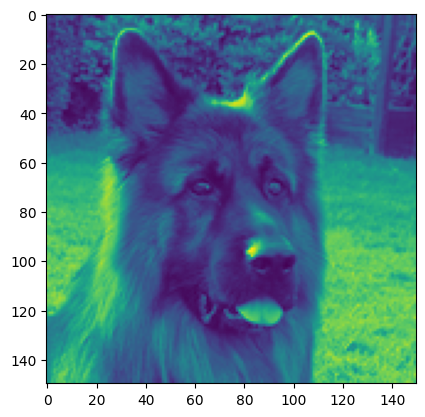

In [12]:
#### To plot and check any random image from the processed data
import random as rd
def plot_random_image():

    rd_img = rd.randint(0,len(X_data))
    print('Image Number - ', rd_img)
    plt.imshow(X_data[rd_img].reshape(img_rows,img_cols,1))
    
    return None 

plot_random_image()

In [13]:
input_shape = X_data.shape[1]

num_classes = len(np.unique(Y_labls))
print('Number of classes in the Data-set for this task is ---- ', num_classes)

Number of classes in the Data-set for this task is ----  3


### Defining a two-hidden layers Neural Network --  

Now we define a simpel Neural Network for image classification..

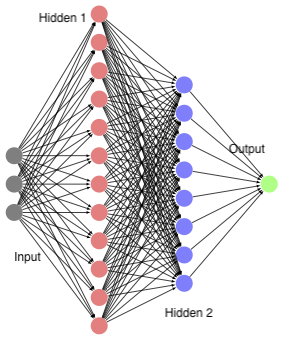

The image above shows two hidden layers with 12 and 8 units respectively. We flatten the input data to be fed into a 
Dense layer. 

In [14]:
model_1 = Sequential()

model_1.add(Dense(12,input_shape=(input_shape,), activation='relu', kernel_initializer='he_uniform'))
model_1.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
model_1.add(Dense(num_classes, activation='softmax'))

In [15]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                270012    
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 3)                 27        
                                                                 
Total params: 270,143
Trainable params: 270,143
Non-trainable params: 0
_________________________________________________________________


In [16]:
loss_function = CategoricalCrossentropy(from_logits=True)

In [17]:
model_1.compile(loss=loss_function, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),\
              metrics=['accuracy'])


In [18]:
#### to ge the output shape from each layer 

for layers in model_1.layers:
    
    print(layers.output_shape)

(None, 12)
(None, 8)
(None, 3)


In [ ]:
#### fitting the model
epochs_1 = 10
history = model_1.fit(X_train, Y_train, epochs=epochs_1, batch_size=20, verbose=1, validation_split=0.2)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


469/469 [==============================] - 4s 7ms/step - loss: 1.1439 - accuracy: 0.3480 - val_loss: 1.0976 - val_accuracy: 0.3580
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 1.0981 - accuracy: 0.3508 - val_loss: 1.0974 - val_accuracy: 0.3580
Epoch 3/10
379/469 [=======================>......] - ETA: 0s - loss: 1.0978 - accuracy: 0.3529

In [ ]:
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(121)
bx = fig.add_subplot(122)

ax.plot(range(epochs_1),history.history['accuracy'],'--o')
ax.set_ylabel('Accuracy')

bx.plot(range(epochs_1),history.history['loss'],'--s')
bx.set_ylabel('Loss')
bx.set_xlabel('Epochs')

fig.tight_layout()
plt.show()

> We see that the accuracy is fixed and doesn't change at all. This remains the same even if we run for more epochs. 
The accuracy is close to 35% which is roughly 1/3 rd. Since the number of classes are 3 we can expect this accuracy by chance. Therefore, the Neural Network don't learn any significant information. 

This happens because in the architecture above .... each pixel is treated as separate feature and the spatial relavance between pixels is not considered. Therefore we move to a more sophisticated architecture of CNN. 

### Using the Convolution layers with padding and pooling 

The architecture is as follows: 

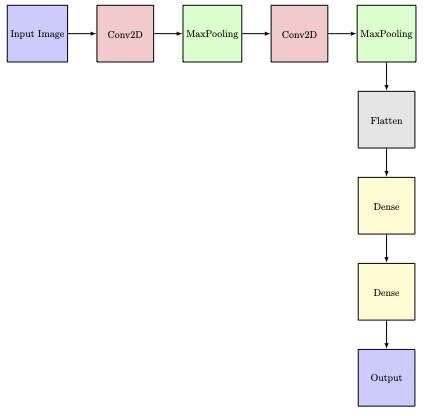

In [ ]:
## Creating another data-set

species = ['cat','dog','wild']

X_cat,Y_cat,_,_,_ = create_dataset_from_path(root_path+'cat/',img_rows,img_cols,'cat',chnl=3)
X_dog,Y_dog,_,_,_ = create_dataset_from_path(root_path+'dog/',img_rows,img_cols,'dog',chnl=3)
X_wild,Y_wild,_,_,_ = create_dataset_from_path(root_path+'wild/',img_rows,img_cols,'wild',chnl=3)

X_data = np.vstack([X_cat,X_dog,X_wild])
Y_labls = np.hstack([Y_cat,Y_dog,Y_wild])

In [ ]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(np.array(Y_labls).reshape(-1,1))

y_train = one_hot_encoder.transform(np.array(Y_labls).reshape(-1,1))

*We should always scale and normalize the input data*

In [ ]:
X_data = X_data.astype('float32')/255

X_train, x_test, Y_train, y_test = train_test_split(X_data,y_train,shuffle=True,stratify=Y_labls,test_size=0.2)


In [ ]:
input_shape = X_data.shape[1:]
print(input_shape)
num_classes = len(np.unique(Y_labls))
num_classes

In [ ]:
model_2 = Sequential()

model_2.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',\
                   input_shape=input_shape,\
                   kernel_initializer='he_uniform',\
                   activation='relu'))

model_2.add(MaxPooling2D((2, 2)))

model_2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_2.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(MaxPooling2D((2, 2)))

model_2.add(Flatten())
model_2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_2.add(Dense(num_classes, activation='softmax'))
model_2.summary()

In [ ]:
# compile model
model_2.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_2 = model_2.fit(X_train, Y_train,
              batch_size=20,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(6,3),)

ax[0].plot(range(10),history_2.history['loss'],'--o',label='Loss')
ax[0].plot(range(10),history_2.history['val_loss'],'--s',label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()


ax[1].plot(range(10),history_2.history['accuracy'],'--o',label='Accuracy')
ax[1].plot(range(10),history_2.history['val_accuracy'],'--s',label='Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()

plt.tight_layout()
plt.show()

#### Discussion 
    1. We showcase how using the CNN helps in working with image data-set. 
    2. We highlight key points to be remembered while processing the data-set. 
    
#### Perspective - 

The CNN architecture is good for working with supervising tasks on image data. However, for Unsupervised machine learning tasks we should explore other Deep Learning models such as Encoder-Decoders. 